In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

dataset_dir = r'C:\Users\erogl\Desktop\BowelDataset'

class_names = ['Normal', 'Polyp', 'Cancer', 'Crohns', 'UC']

images = []
labels = []

for class_index, class_name in enumerate(class_names):
    class_dir = os.path.join(dataset_dir, class_name)
    for filename in os.listdir(class_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(class_dir, filename)
            image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))  # Görüntü boyutu ayarlandı
            image = image.astype('float32') / 255.0
            image = cv2.GaussianBlur(image, (5, 5), 0)  # Gaussian gürültü giderme uygulandı
            labels.append(class_index)
            images.append(image)

X = np.array(images)
y = np.array(labels)

In [2]:
# Veri artırma
datagen = ImageDataGenerator(
    rotation_range=15, 
    horizontal_flip = True, 
    height_shift_range=0.2,  
    zoom_range=0.3,  
)

X_augmented = []
y_augmented = []

target_classes = [0, 2, 3]  # Yalnızca bu sınıflar için artırma yapıldı

for i in range(len(X)):
    x = X[i].reshape((1,) + X[i].shape)  # (1, 224, 224, 3)
    current_class = y[i]
    
    if current_class in target_classes:
        augmentation_count = 2  # Her görüntü için artırılacak görüntü sayısı belirlendi
        generated_count = 0

        for batch in datagen.flow(x, batch_size=1):
            X_augmented.append(batch[0]) 
            y_augmented.append(current_class)
            generated_count += 1
            if generated_count >= augmentation_count:
                break

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

# Boyut kontrolü yapıldı
print(f"Orijinal veri şekli: {X.shape}")
print(f"Artırılmış veri şekli: {X_augmented.shape}")

X_combined = np.concatenate((X, X_augmented), axis=0) 
y_combined = np.concatenate((y, y_augmented), axis=0)

# Eğitim, doğrulama ve test kümeleri oluşturuldu
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y_combined, test_size=0.3, stratify=y_combined, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Veri standardizasyonu yapıldı
mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std


Orijinal veri şekli: (3570, 224, 224, 3)
Artırılmış veri şekli: (2290, 224, 224, 3)


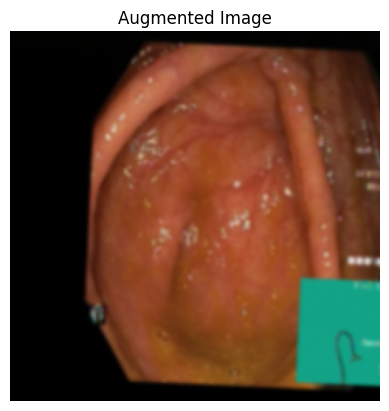

In [3]:
import matplotlib.pyplot as plt

sample_index = 0  
augmented_image = X_augmented[sample_index]

plt.imshow(augmented_image)
plt.title("Augmented Image")
plt.axis('off')
plt.show()


In [4]:
#Veri sayılarını gösterme kısmı 
print(f"Veri artırmadan önceki toplam veri sayısı: {len(X)}")

print("Veri artırmadan önceki sınıf dağılımları:")
for class_label, count in Counter(y).items():
    print(f"  Sınıf {class_names[class_label]}: {count} görüntü")

print(f"Veri artırmadan sonraki toplam veri sayısı: {len(X_combined)}")

print("Veri artırmadan sonraki sınıf dağılımları:")
for class_label, count in Counter(y_combined).items():
    print(f"  Sınıf {class_names[class_label]}: {count} görüntü")

Veri artırmadan önceki toplam veri sayısı: 3570
Veri artırmadan önceki sınıf dağılımları:
  Sınıf Normal: 741 görüntü
  Sınıf Polyp: 1200 görüntü
  Sınıf Cancer: 286 görüntü
  Sınıf Crohns: 118 görüntü
  Sınıf UC: 1225 görüntü
Veri artırmadan sonraki toplam veri sayısı: 5860
Veri artırmadan sonraki sınıf dağılımları:
  Sınıf Normal: 2223 görüntü
  Sınıf Polyp: 1200 görüntü
  Sınıf Cancer: 858 görüntü
  Sınıf Crohns: 354 görüntü
  Sınıf UC: 1225 görüntü


In [5]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# EfficientNet modeli 
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.6)(x)

output = Dense(len(class_names), activation='softmax',
               kernel_regularizer=tf.keras.regularizers.l2(0.02))(x) 

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    min_delta=0.001
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

datagen_val = ImageDataGenerator()  

# Model eğitimi 
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_val, y_val),
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

# Model değerlendirmesi
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(X_test, batch_size=32), axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))

Epoch 1/30
257/257 [==============================] - 500s 2s/step - loss: 0.8542 - accuracy: 0.7850 - val_loss: 2.2156 - val_accuracy: 0.2639 - lr: 0.0010
Epoch 2/30
257/257 [==============================] - 490s 2s/step - loss: 0.5500 - accuracy: 0.8618 - val_loss: 2.1149 - val_accuracy: 0.1638 - lr: 0.0010
Epoch 3/30
257/257 [==============================] - 502s 2s/step - loss: 0.4292 - accuracy: 0.8857 - val_loss: 8.4894 - val_accuracy: 0.2651 - lr: 0.0010
Epoch 4/30
257/257 [==============================] - 493s 2s/step - loss: 0.3581 - accuracy: 0.9020 - val_loss: 2.6106 - val_accuracy: 0.0853 - lr: 0.0010
Epoch 5/30
257/257 [==============================] - 494s 2s/step - loss: 0.3483 - accuracy: 0.9096 - val_loss: 1.4618 - val_accuracy: 0.5495 - lr: 0.0010
Epoch 6/30
257/257 [==============================] - 500s 2s/step - loss: 0.2918 - accuracy: 0.9235 - val_loss: 3.4648 - val_accuracy: 0.2218 - lr: 0.0010
Epoch 7/30
257/257 [==============================] - 494s 2s/st

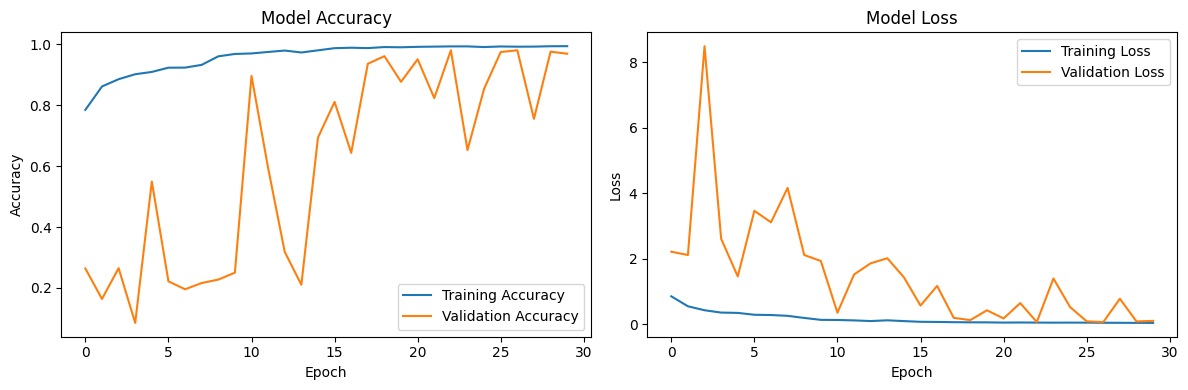

In [6]:
plt.figure(figsize=(12, 4))

# Accuracy grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

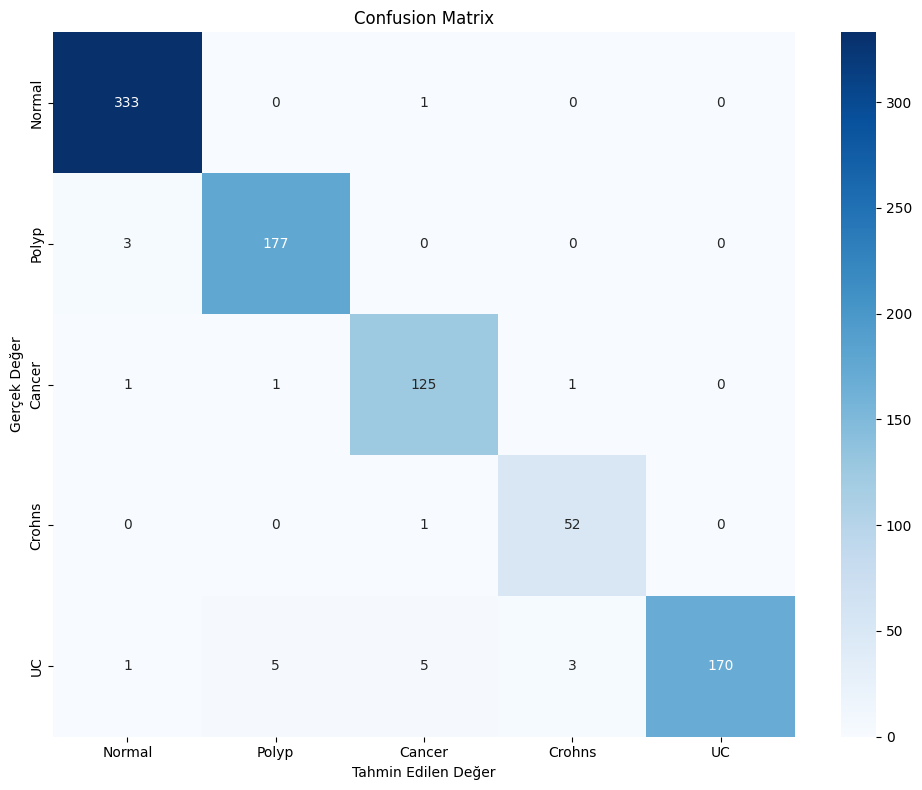

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

#Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Edilen Değer')
plt.tight_layout()
plt.show()

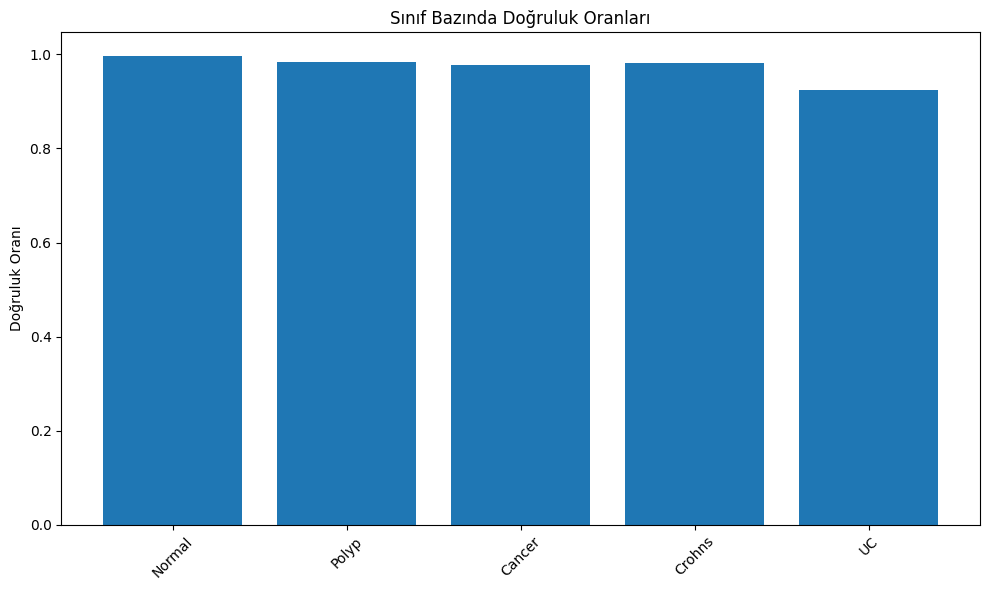

In [8]:
class_accuracies = cm.diagonal()/cm.sum(axis=1)
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_accuracies)
plt.title('Sınıf Bazında Doğruluk Oranları')
plt.ylabel('Doğruluk Oranı')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()